# G$^2$Pnet for local tree structure

Created: 04/18/16,   Last Edit: 04/21/16


For large graph, the key issue is to distinguish from different graph topology. A typical graph structure is the hierarchical model with each layer representing a local clustering 

In [21]:
%reset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
import GPy
import GPy.util as gutil

%matplotlib inline 
plt.close('all')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [22]:
Ifsavefig =  True
Ifsavedata = True
trial = 0

## Random Partition Graph and graph signals

Consider the random partition graph with group parition as $[n_1, n_2, \ldots, n_{k}]$, where the nodes in the same group are connected with probability $p_{in}$ and nodes with different groups are connected with prob. $p_{out}$. That is $\mathcal{G}= (\mathcal{V}, \mathcal{E}) \approx \bigcup_{i=1}^{k}\mathcal{G}_{i}$.

In [23]:
n = 40
m = 40
partition_size = [n,m]  #[40,20,10]
p_in = 0.55
p_out = 0.05
G = nx.random_partition_graph(partition_size, p_in, p_out, seed=250)

G.remove_edges_from(G.selfloop_edges())

label = np.zeros([n+m,1])
label[n:n+m] = np.ones([m,1])
#### labeling of the cluster
for node in G.nodes():
    G.node[node]['category'] = int(label[node,0])

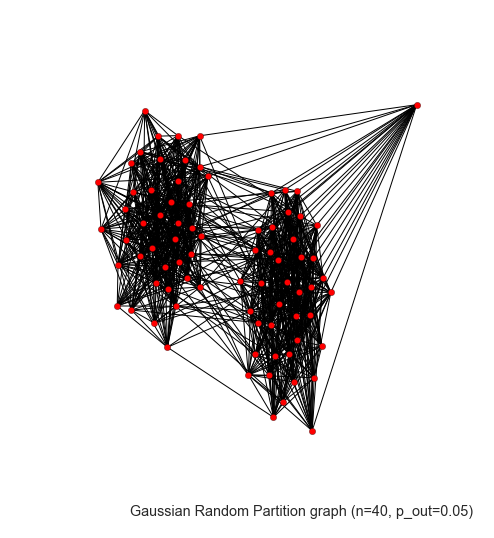

In [24]:
size = 40
fig= plt.figure(1)
fig.set_size_inches(8.0, 8.0)


ax1 = plt.axes()
#ax = fig.add_axes([0, 0, 1.5, 1.5])

pos_spring = nx.spring_layout(G)


ax=nx.draw(G, pos=pos_spring, node_size = size)  
#ax=nx.draw(G, pos=pos_spectral, node_size = size)  
limits=plt.axis('off') # turn of axis
txt = "Gaussian Random Partition graph (" + "n=" + str(n) + ", p_out={0:.2f})".format(p_out) 
plt.text(0.1,-0.1,txt, fontsize='x-large')
fig.subplots_adjust(wspace=0.3, top= 1)
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_sprLayout.eps"
    fig.savefig(file_org +file_tail )  

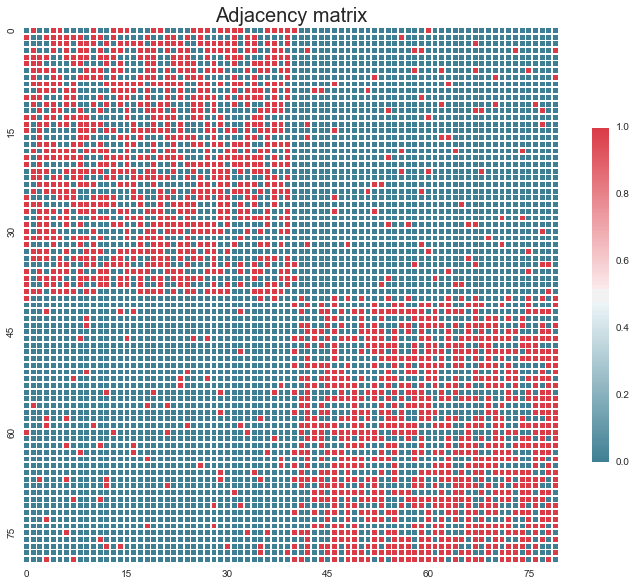

In [25]:
A = nx.adjacency_matrix(G)
fig= plt.figure(2)
fig.set_size_inches(12.0, 12.0)
sns.set(style="white")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = plt.axes()
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(A.todense(), cmap=cmap, vmax=1, #.3,
            square=True, xticklabels=15, yticklabels=15,
            linewidths=.8, cbar_kws={"shrink": .5}, ax=ax)
ax.set_title('Adjacency matrix', fontsize = 20)
plt.show()
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_adjMat.eps"
    fig.savefig(file_org + file_tail )  

In [26]:
####generate the eigenspace of normalized Laplacian
k = 3
nnodes = nx.adjacency_matrix(G).shape[0]

ncv=max(2*k+1,int(np.sqrt(nnodes)))

eigenvalues,eigenvectors= sp.sparse.linalg.eigsh(nx.laplacian_matrix(G).asfptype(), k=k, \
                                                which='SM', return_eigenvectors = True, ncv=ncv)
index=np.argsort(eigenvalues)[1:k] # 0 index is zero eigenvalue    
pos_spectral_mat = np.real(eigenvectors[:,index]) #pos_spectral_mat is the spectral location of the nodes
pos_spectral_df = pd.DataFrame(data=pos_spectral_mat, columns=['PX','PY'], dtype=float)
pos_spectral_df['LABEL'] = label
U = pos_spectral_mat

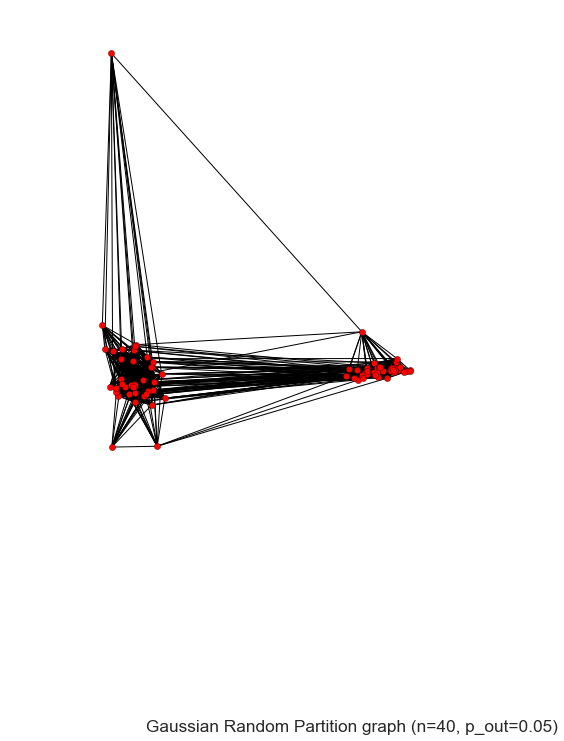

In [27]:
size = 40
fig= plt.figure(3)
fig.set_size_inches(8.0, 8.0)


ax1 = plt.axes()
pos_spectral = nx.spectral_layout(G)

#ax=nx.draw(G, pos=pos_spring, node_size = size)  
ax=nx.draw(G, pos=pos_spectral_mat, node_size = size)  
limits=plt.axis('off') # turn of axis
txt = "Gaussian Random Partition graph (" + "n=" + str(n) + ", p_out={0:.2f})".format(p_out) 
plt.text(-0.1,-1,txt, fontsize='x-large')
fig.subplots_adjust(wspace=0.3, top= 1)
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_spLayout.eps"
    fig.savefig(file_org + file_tail )  

In [28]:
T= 2
c = 2*np.pi*0.8
data_np = np.zeros([nnodes, T])
column_name = []
for t in np.arange(1,T+1):
    temp1 = np.multiply(pos_spectral_df['PX'].apply(lambda x: np.exp(-c*t*x)).values, \
                          pos_spectral_df['PY'].apply(lambda y: np.cos(c*t*y)).values)
    data_np[:,t-1] = temp1
    if t == 1:
        column_name = str(t-1)+"_cos"
    else:    
        column_name = [column_name, str(t-1)+"_cos"]

sigma = 0.1        
data_np = np.add(data_np, sigma*np.random.randn(nnodes, T))   
X = data_np
data_df = pd.DataFrame(data=data_np, columns=column_name, dtype=float)
data_df['LABEL'] = label

In [29]:
if Ifsavedata:
    nx.write_adjlist(G, "../data/04_21_2016_experiment"+ str(trial) +".adjlist",delimiter=',')
    nx.write_edgelist(G, "../data/04_21_2016_experiment" + str(trial) + ".edgelist")

    np.savez("../data/04_21_2016_experiment" + str(trial) + "_data.npz", pos_spectral_mat, data_np, label)
    data_df.to_csv("../data/04_21_2016_experiment" + str(trial) + "_X.csv", index_label= 'ID')
    pos_spectral_df.to_csv("../data/04_21_2016_experiment" +  str(trial)  + "_U.csv", index_label= 'ID')

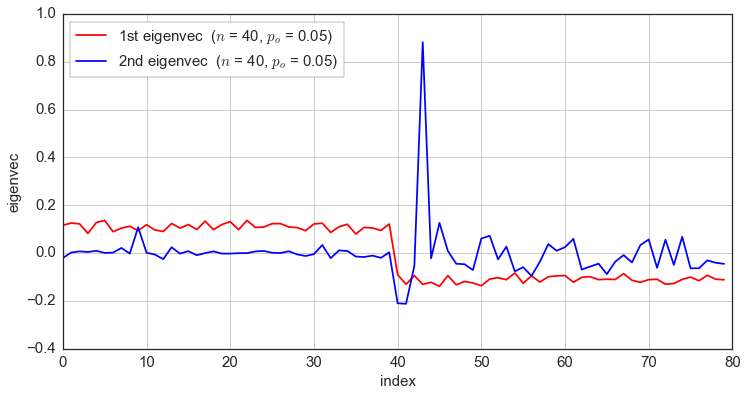

In [30]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0)
plt.style.use('seaborn-white')


ax = plt.gca()
h1, = plt.plot(np.arange(nnodes), pos_spectral_mat[:,0], '-r')
h2, = plt.plot(np.arange(nnodes), pos_spectral_mat[:,1], '-b')
ax.legend([h1, h2], [r"1st eigenvec  ($n$ = {0:2d}, $p_o$ = {1:3.2f})".format(n, p_out), \
                         r"2nd eigenvec  ($n$ = {0:2d}, $p_o$ = {1:3.2f})".format(n, p_out)], \
                             fontsize = 15, loc='upper left', frameon=True)
plt.grid(1)
plt.ylabel('eigenvec', fontsize = 15)
plt.xlabel('index', fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    #ax.set_ylim([50, 120])
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_U_partition.eps"
    fig.savefig(file_org  + file_tail )  

In [31]:
nsample, ndim = X.shape
_ , ndim_latent = U.shape

In [32]:
import sys
import os
dirorg = os.path.dirname(os.getcwd())
sys.path.insert(0, dirorg+"/src/")

In [33]:
import G2PnetSolver#G2PnetSolver_v2
#from imp import reload
#reload(G2PnetSolver_v2)

In [34]:
from G2PnetSolver import  G2PnetSolver as Solver
from G2PnetSolver import  Grassmann_update, check_step

In [35]:
choice = "near"
IfGen = True

In [36]:
if IfGen:
    np.random.seed(seed=150)

    if choice == "random":
        print("Random Initialization")
        Temp = np.random.randn(nsample, nsample)
        Temp_sym = (Temp + Temp.T) / 2 
        _, U_temp = np.linalg.eig(Temp_sym)
        U_test = U_temp[:, np.arange(ndim_latent)]
        U0 = U_test
    elif choice == "near":
        print("Initialization in neigborhood.")
        U0 = U

    ones = np.ones([nsample,])/np.sqrt(nsample)
    eta0 = 0.75
    np.random.seed(seed=220)
    G_temp = np.random.randn(nsample, ndim_latent) / (np.sqrt(nsample * ndim_latent))
    H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(np.column_stack((U0, ones)))),G_temp)
    print(str(check_step(H_temp, eta0)))

    while not check_step(H_temp, eta0):
        np.random.seed(seed=160)
        G_temp = np.random.randn(nsample, ndim_latent) / np.sqrt(nsample * ndim_latent)
        H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(np.column_stack((U0, ones)))),G_temp)
    U_init, dU = Grassmann_update(U0, H_temp, eta=eta0)
    np.linalg.norm(dU)

Initialization in neigborhood.
True


In [37]:
if Ifsavedata:
    U_columns = [str(i) for i in np.arange(ndim_latent)]
    U_df = pd.DataFrame(data = U_init, columns=U_columns, dtype= float)
    if choice == "random":
        U_df['RANDOM'] = np.ones([nsample, 1])
    elif choice == "near":
        U_df['RANDOM'] = np.zeros([nsample, 1])
    
    U_df.to_csv("../data/04_21_16_" + str(trial)  + "_U_init.csv")

##  Random Process on nodes

A generative model for the node feature is 
\begin{align}
x^{v} &= f(\mathbf{u}^{v}) + n^{v}
\end{align} where $\mathbf{u}^{v}$ is the $v$-th row of eigenmatrix $\mathbf{U}$ of Laplacian, i.e. $$\mathbf{L}= \mathbf{U}\boldsymbol{\Lambda}\mathbf{U}^{T}$$

Here the function $f$ is of concern. Assume there is a smooth invertible coordinate map $\varphi: \mathcal{V} \rightarrow \mathcal{U}\subset \mathbb{R}^{k}$ so that each node $v\in \mathcal{V}$ is associated with a vector representation $\varphi(v) = (\mathbf{U}^{v})^{T} \in \mathbb{R}^{k}$.

### Gaussian Process on Graph
For Gaussian Process, $f: \mathbb{R}^{k}\rightarrow \mathbb{R}$ is real valued random function on continuous Euclidean space. The  PD covariance matrix is given as 
\begin{align}
\mathbf{K}_{\mathbf{U}} &= [K\left(\mathbf{U}^{m}, \mathbf{U}^{n}\right)] \\
&= \left[\mathbb{E}[f(\mathbf{U}^{m})\,f(\mathbf{U}^{n})]\right]
\end{align}
for linear kernel, 
\begin{align}
\mathbf{K}_{\mathbf{U}} &= \mathbf{U}^{}\,\mathbf{U}^{T} + \beta\mathbf{I}\\
\mathbf{P}_{K}:= \mathbf{K}_{\mathbf{U}}^{-1}&= \beta^{-1}\mathbf{I} - \beta^{-1}\mathbf{U}^{}\,\left( \frac{1}{1+\beta}\mathbf{I} \right)\mathbf{U}^{T}
\end{align}

### The Graph signal
For graph signal, $g: \mathcal{V} \rightarrow \mathbb{R}$ is a function on discrete graph node domain. The PD covariance matrix is given as 
\begin{align}
\boldsymbol{\Sigma}_{\mathbf{U}} &=[\mathbb{E}[g(m)\,g(n)]]\\
&=[\mathbf{P}]^{-1}\\
\mathbf{P}&= \mathbf{U}h(\boldsymbol{\Lambda})\mathbf{U}^{T}:= h(\mathbf{L})\\
\end{align}  where $h(\lambda_{v}) >0$, if $\lambda_{v} > 0$ and $h(\lambda_{v})=0$ if $\lambda_{v}= 0$.
Note that the graph signal is reconstructed from the Graph Fourier Transform via a linear transformation.
\begin{align}
g &=  \langle g^{*}, \varphi \rangle,
\end{align} where $g^{*}\in \mathbb{R}^{k}$ is the Graph Fourier Transform.
And $$ g_f = f\circ \varphi : \mathcal{V} \rightarrow \mathbb{R}$$ is seen as a graph signal if $f(\cdot):= <g^{*}, \cdot>$ is linear inner product with $g^{*}$ randomly distributed from $\mathcal{N}(0,I)$.

This reveals the connection between a graph signal and a Gaussian process on graph: 

 __A "Gaussian white noise" graph signal is the mean function of a Gaussian process on graph that applies the linear kernel $K$ __.
 
In other word, both graph signal and the Gaussian Process on Graph becomes the PCA when the graph signal is "stationary" and the kernel is linear.


### Questions 
1. By continuity of the sample path $f$ of the Gaussian process, this is __True__ for $f^{-1}([y_{v}-\epsilon, y_{v}+\epsilon]) \subset \mathcal{U}_{v}:= \mathcal{N}(\mathbf{U}^{v})\cap \mathcal{M}$, where $y_{v}= f(\mathbf{U}^{v})$. 

2. We are interested in the __continuity__ of $g_{f}$, i.e. for $y\in B \supset [y_{v}-\epsilon, y_{v}+\epsilon]$, is there $v'\in \mathcal{N}(v)\cap\mathcal{V}$ s.t. $\;\; \text{Pr}\{|| y - g_f(v') || \le \epsilon \} \ge 1-\delta$ ? 

3. Consider $\varphi: \mathcal{V} \rightarrow \mathcal{U}\subset \mathbb{R}^{k}$. The question is that __ for given $\mathbf{U}^{v} = \varphi(v) \in  \mathcal{U}_{v}$, the neighborhood in manifold $\mathcal{M} \subset \mathbb{R}^{k}$, is $\varphi^{-1}(\mathcal{U}_{v}) \subset \mathcal{N}(v)$ ? __

4. Is $\varphi: \mathcal{V} \rightarrow \mathcal{U}\subset \mathbb{R}^{k}$ one-to-one ? 

    No. For spectral clutering and the stochastic block model, nodes in the same community tends to have the same representation. As a consequence, $g_f = f\circ \varphi$ is not one-to-one.
   
5. For $\mathbf{U}=\varphi(v')\not\in \mathcal{U}_{v}$, $v' \not\in \mathcal{N}(v)$ ?  In fact, for stochastic block model, $\varphi$ is continuous, i.e. $\varphi^{-1}(\mathcal{U}_{v})= \mathcal{N}(v)\cap \mathcal{V}$.

6. The __identification__ problem: if $y_1 \not\in B \supset [y_{0}-\epsilon, y_{0}+\epsilon]$, does the corresponding $v_1 \not\in \mathcal{N}(v_{0})= (f\circ \varphi)^{-1}(B)\cap \mathcal{V}$? 
   i.e. __is $g_{f} = f\circ \varphi: \mathcal{V}\rightarrow \mathbb{R}$ one-to-one__ ? 



### Learning subspace $\mathbf{U}$ as learning $\varphi: v\mapsto \mathbf{U}^{v}$ ?
